In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import nltk
#downloading required packages

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    tokens0 = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens1 = [word for word in tokens0 if word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens1]
    preprocessed_text = ' '.join(tokens)
    return preprocessed_text

train_data['clean_tweet'] = train_data['Tweet'].apply(preprocess_text)
test_data['clean_tweet'] = test_data['Tweet'].apply(preprocess_text)

# apply balanceing the dataset
spam_data = train_data[train_data['Type'] == 'Spam']
quality_data = train_data[train_data['Type'] == 'Quality']
num_samples = min(len(spam_data), len(quality_data))
spam_data_resampled = resample(spam_data, replace=True, n_samples=num_samples, random_state=42)
quality_data_resampled = resample(quality_data, replace=True, n_samples=num_samples, random_state=42)
balanced_data = pd.concat([spam_data_resampled, quality_data_resampled])

X = balanced_data['clean_tweet']
y = balanced_data['Type'].map({'Quality': 0, 'Spam': 1})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

X_train_tensor = torch.tensor(X_train_vectorized.toarray()).float()
X_test_tensor = torch.tensor(X_test_vectorized.toarray()).float()
y_train_tensor = torch.tensor(y_train.values).long()
y_test_tensor = torch.tensor(y_test.values).long()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


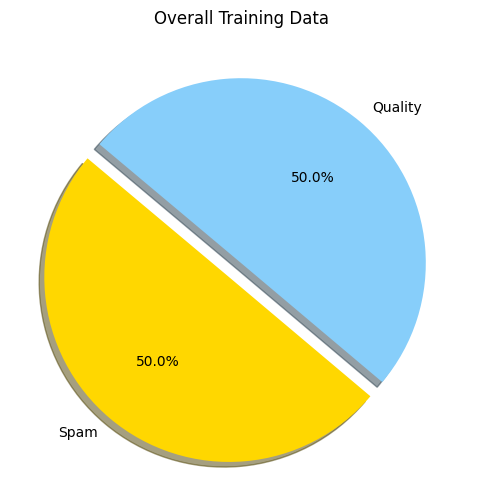

In [ ]:
import matplotlib.pyplot as plt

original_spam_count = train_data[train_data['Type'] == 'Spam'].shape[0]
original_quality_count = train_data[train_data['Type'] == 'Quality'].shape[0]

labels = ['Spam', 'Quality']
sizes = [original_spam_count, original_quality_count]
colors = ['gold', 'lightskyblue']
explode = (0.1, 0)
plt.figure(figsize=(6, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Overall Training Data')

plt.show()


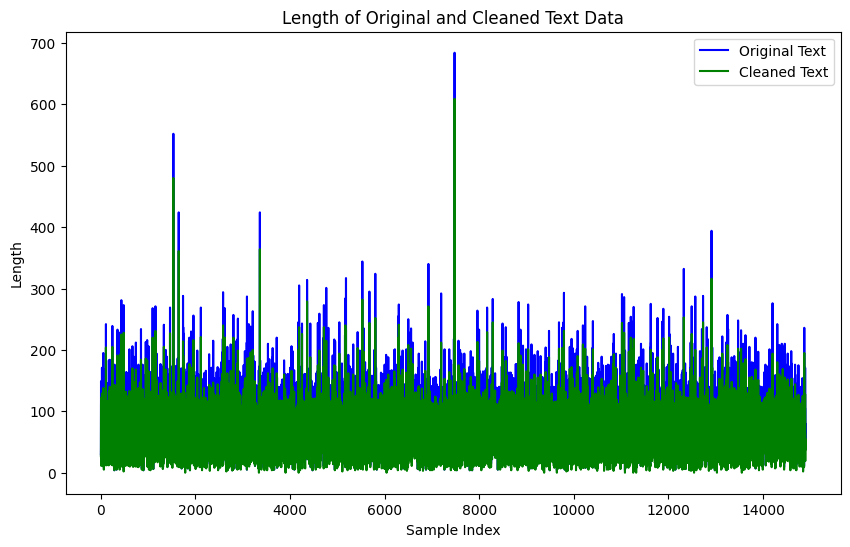

In [ ]:
original_lengths = [len(text) for text in train_data['Tweet']]
cleaned_lengths = [len(text) for text in train_data['clean_tweet']]

plt.figure(figsize=(10, 6))
plt.plot(original_lengths, label='Original Text', color='blue')
plt.plot(cleaned_lengths, label='Cleaned Text', color='green')
plt.title('Length of Original and Cleaned Text Data')
plt.xlabel('Sample Index')
plt.ylabel('Length')
plt.legend()
plt.show()


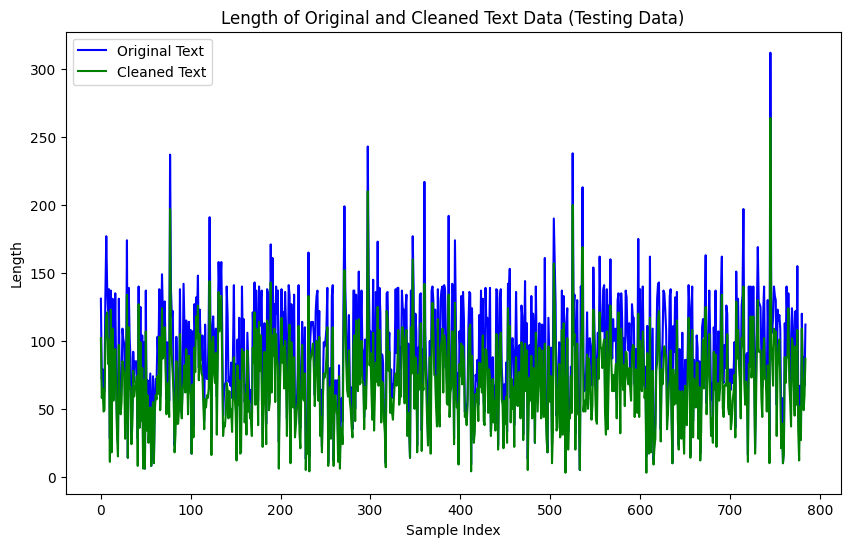

In [ ]:
test_original_lengths = [len(text) for text in test_data['Tweet']]
test_cleaned_lengths = [len(text) for text in test_data['clean_tweet']]

plt.figure(figsize=(10, 6))
plt.plot(test_original_lengths, label='Original Text', color='blue')
plt.plot(test_cleaned_lengths, label='Cleaned Text', color='green')
plt.title('Length of Original and Cleaned Text Data (Testing Data)')
plt.xlabel('Sample Index')
plt.ylabel('Length')
plt.legend()
plt.show()


In [ ]:
#Define the model
import torch.nn as nn
import torch.nn.functional as F

class InputEmbedding(nn.Module):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)

    def forward(self, x):
        x = x.long()
        return self.embedding(x)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5573):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(1).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.activation = F.relu

    def forward(self, src, src_mask=None, src_key_padding_mask=None):
        src2 = self.self_attn(src, src, src, attn_mask=src_mask, key_padding_mask=src_key_padding_mask)[0]
        src = src + self.dropout1(src2)
        src = self.norm1(src)
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = src + self.dropout2(src2)
        src = self.norm2(src)
        return src

class TransformerEncoder(nn.Module):
    def __init__(self, encoder_layer, num_layers):
        super().__init__()
        self.layers = nn.ModuleList([copy.deepcopy(encoder_layer) for _ in range(num_layers)])

    def forward(self, src, mask=None, src_key_padding_mask=None):
        for layer in self.layers:
            src = layer(src, src_mask=mask, src_key_padding_mask=src_key_padding_mask)
        return src

class TransformerDecoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1):
        super().__init__()
        self.mha_self = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        self.ln1 = nn.LayerNorm(d_model)
        self.mha_src = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        self.ln2 = nn.LayerNorm(d_model)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.ReLU(),
            nn.Linear(dim_feedforward, d_model)
        )

    def forward(self, trg, enc_src, trg_mask=None, src_mask=None, trg_key_padding_mask=None, src_key_padding_mask=None):
        x, _ = self.mha_self(trg, trg, trg, attn_mask=trg_mask, key_padding_mask=trg_key_padding_mask)
        x = self.ln1(x)
        x, _ = self.mha_src(x, enc_src, enc_src, attn_mask=src_mask, key_padding_mask=src_key_padding_mask)
        x = self.ln2(x)
        x = x + self.ffn(x)
        return x

class TransformerDecoder(nn.Module):
    def __init__(self, decoder_layer, num_layers):
        super().__init__()
        self.layers = nn.ModuleList([decoder_layer for _ in range(num_layers)])

    def forward(self, x, enc_src, trg_mask=None, src_mask=None, trg_key_padding_mask=None, src_key_padding_mask=None):
        for layer in self.layers:
            x = layer(x, enc_src, trg_mask=trg_mask, src_mask=src_mask, trg_key_padding_mask=trg_key_padding_mask, src_key_padding_mask=src_key_padding_mask)
        return x

class TransformerModel(nn.Module):
    def __init__(self, vocab_size, d_model, nhead, num_layers, dim_feedforward=2048, dropout=0.1):
        super().__init__()
        self.embedding = InputEmbedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, dropout)
        self.encoder = TransformerEncoder(TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout), num_layers)
        self.decoder = TransformerDecoder(TransformerDecoderLayer(d_model, nhead, dim_feedforward, dropout), num_layers)
        self.fc = nn.Linear(d_model, 2)

    def forward(self, x, enc_x=None):
        x = self.embedding(x) * torch.sqrt(torch.tensor(self.embedding.embedding.embedding_dim, device=x.device))
        x = self.pos_encoding(x)
        if enc_x is not None:
            enc_x = self.encoder(enc_x)
            x = self.decoder(x, enc_x)
        x = self.fc(x[:, 0, :])
        return x

class SimpleClassifier(nn.Module):
    def __init__(self, input_dim, output_dim=2):
        super(SimpleClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, output_dim)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [ ]:

input_dim = X_train_tensor.shape[1]
model = SimpleClassifier(input_dim)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

train_accuracies = []
test_accuracies = []

def train(model, criterion, optimizer, X_train, y_train, X_test, y_test, epochs=10, batch_size=64):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for i in range(0, len(X_train), batch_size):
            inputs = X_train[i:i+batch_size]
            labels = y_train[i:i+batch_size]
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted_train = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted_train == labels).sum().item()
        epoch_loss = running_loss / len(X_train)
        epoch_acc_train = 100*(correct_train / total_train)
        train_accuracies.append(epoch_acc_train)

        model.eval()
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for i in range(0, len(X_test), batch_size):
                inputs_test = X_test[i:i+batch_size]
                labels_test = y_test[i:i+batch_size]
                outputs_test = model(inputs_test)
                _, predicted_test = torch.max(outputs_test.data, 1)
                total_test += labels_test.size(0)
                correct_test += (predicted_test == labels_test).sum().item()
            epoch_acc_test = 100*(correct_test / total_test)
            test_accuracies.append(epoch_acc_test)

        print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc_train:.4f}, Test Accuracy: {epoch_acc_test:.4f}')

train(model, criterion, optimizer, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor)
def evaluate_overall_accuracy(model, X_test, y_test, batch_size=64):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for i in range(0, len(X_test), batch_size):
            inputs = X_test[i:i+batch_size]
            labels = y_test[i:i+batch_size]
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    overall_accuracy = (correct / total) * 100
    print(f'Overall Accuracy: {overall_accuracy:.2f}%')
    return overall_accuracy

accr=evaluate_overall_accuracy(model, X_test_tensor, y_test_tensor)


Epoch 1/10, Loss: 0.0109, Train Accuracy: 53.4011, Test Accuracy: 72.8677
Epoch 3/10, Loss: 0.0067, Train Accuracy: 88.8310, Test Accuracy: 85.2921
Epoch 4/10, Loss: 0.0038, Train Accuracy: 93.0047, Test Accuracy: 87.2398
Epoch 5/10, Loss: 0.0023, Train Accuracy: 95.8935, Test Accuracy: 88.3815
Epoch 7/10, Loss: 0.0010, Train Accuracy: 98.4044, Test Accuracy: 89.5567
Epoch 8/10, Loss: 0.0007, Train Accuracy: 99.0343, Test Accuracy: 89.7918
Epoch 9/10, Loss: 0.0005, Train Accuracy: 99.3870, Test Accuracy: 89.6239
Epoch 10/10, Loss: 0.0004, Train Accuracy: 99.5129, Test Accuracy: 89.5567
Overall Accuracy: 89.56%


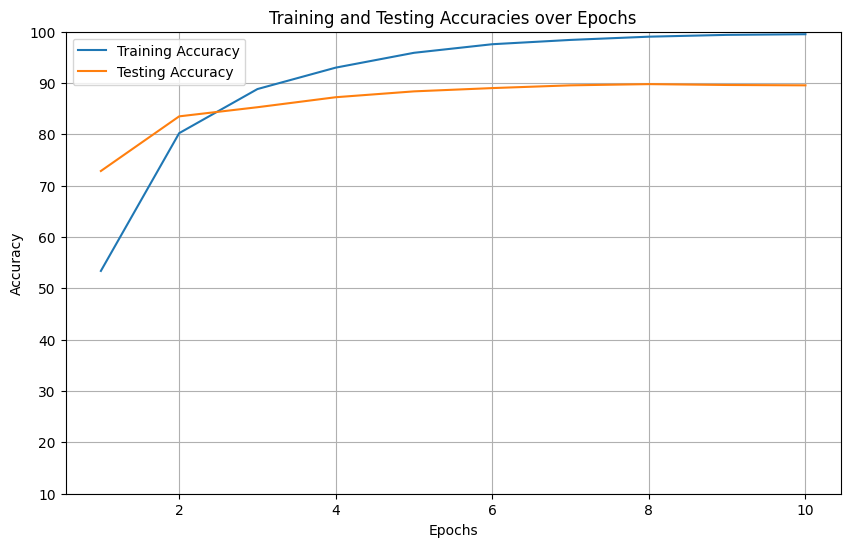

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
epochs = range(1, len(train_accuracies) + 1)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, test_accuracies, label='Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracies over Epochs')
plt.legend()
plt.grid(True)

# Set y-axis limits from 10% to 100%
plt.ylim(10, 100)

plt.show()


In [ ]:




def predict_message_simple_classifier(model, message, vectorizer):
    message = preprocess_text(message)

    message_vectorized = vectorizer.transform([message])

    message_tensor = torch.tensor(message_vectorized.toarray()).float()

    with torch.no_grad():
        output = model(message_tensor)
        predicted_class = torch.argmax(output)

    if predicted_class == 0:
        prediction = "Quality"
    else:
        prediction = "Spam"

    return prediction



In [ ]:
def predict_user_input(model, vectorizer):
    user_tweet = input("Enter the tweet text: ")
    prediction = predict_message_simple_classifier(model, user_tweet, vectorizer)
    print(user_tweet)
    print(f"The predicted class is: {prediction}")

predict_user_input(model, vectorizer)

Enter the tweet text: hii
hii
The predicted class is: Quality


In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

def evaluate_model(model, X_test, y_test, batch_size=64):
    model.eval()
    predictions = []
    with torch.no_grad():
        for i in range(0, len(X_test), batch_size):
            inputs = X_test[i:i+batch_size]
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            predictions.extend(predicted.cpu().numpy())
    y_pred = np.array(predictions)

    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    # Print metrics
    print(f'F1 Score: {f1:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print('Confusion Matrix:')
    print(cm)

# Evaluate the model
evaluate_model(model, X_test_tensor, y_test_tensor)


F1 Score: 0.8960
Precision: 0.8981
Recall: 0.8939
Confusion Matrix:
[[1328  152]
 [ 159 1339]]


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

# Function to evaluate models and print confusion matrix
def evaluate_model_with_confusion_matrix(y_true, y_pred, model_name):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    print(f"{model_name} Classifier:")
    print(f"Accuracy: {acc}")
    print(f"F1 Score: {f1}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"Confusion Matrix:\n{cm}\n")

# Random Forest Classifier
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train_vectorized, y_train)
rf_predictions = rf_classifier.predict(X_test_vectorized)
evaluate_model_with_confusion_matrix(y_test, rf_predictions, "Random Forest")

# Naive Bayes Classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_vectorized, y_train)
nb_predictions = nb_classifier.predict(X_test_vectorized)
evaluate_model_with_confusion_matrix(y_test, nb_predictions, "Naive Bayes")

# Logistic Regression Classifier
logistic_classifier = LogisticRegression()
logistic_classifier.fit(X_train_vectorized, y_train)
logistic_predictions = logistic_classifier.predict(X_test_vectorized)
evaluate_model_with_confusion_matrix(y_test, logistic_predictions, "Logistic Regression")


Random Forest Classifier:
Accuracy: 0.8932169241101411
F1 Score: 0.8895833333333333
Precision: 0.926917510853835
Recall: 0.8551401869158879
Confusion Matrix:
[[1379  101]
 [ 217 1281]]

Naive Bayes Classifier:
Accuracy: 0.8690396239086635
F1 Score: 0.8676171079429734
Precision: 0.8825966850828729
Recall: 0.8531375166889186
Confusion Matrix:
[[1310  170]
 [ 220 1278]]

Logistic Regression Classifier:
Accuracy: 0.8546004029550034
F1 Score: 0.8508439545297967
Precision: 0.8790035587188612
Recall: 0.8244325767690254
Confusion Matrix:
[[1310  170]
 [ 263 1235]]



In [ ]:
import matplotlib.pyplot as plt

models = ['Spam Transformer', 'Random Forest', 'Naive Bayes', 'Logistic Regression']

accuracies=[accr,rf_acc*100,nb_acc*100,logistic_acc*100]
print(accuracies)
plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color=['blue', 'green', 'orange', 'red'])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies')
plt.ylim(80, 90)
plt.show()


NameError: name 'rf_acc' is not defined